# Gaussian Imputation

In [9]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
from scipy.stats import t, laplace, norm
import seaborn as sns
from sklearn.datasets import make_spd_matrix
from probml_utils import savefig, latexify
from probml_utils import gauss_utils as gauss
from probml_utils import pyprobml_utils as pml
import os

In [10]:
latexify(width_scale_factor=2, fig_height=3.0, font_size=14)

In [11]:
def plot_hinton_data(data, title, save_name="", graph_pos_ind=1):
    """
    Draw a hinton plot

    Args:
    ----------
    data : JAX array
        Data for the hinton graph

    title : string
        Title for graph

    save_name :  string, default=''
        Filename for the saved graph

    graph_pos_ind :  int, default=1
        Graph position indicator

    Returns:
    ----------
    None
    """

    plot = plt.figure(graph_pos_ind)
    pml.hinton_diagram(data, ax=plot.gca())
    plt.title(title)
    plt.ylabel("Dimension of data")
    plt.xlabel("Number of samples")

    # Generating Legend data based on hinton_diagram function
    # --------------------------------------------------------
    # Flatten the data matrix
    flatten_data = jnp.sort(jnp.abs(jnp.ravel(data)))

    # Calculate max weight
    max_weight = 2 ** jnp.ceil(jnp.log(flatten_data.max()) / jnp.log(2))

    # Get only non zero evenly spaced indexes
    idx = jnp.linspace(
        jnp.flatnonzero(flatten_data)[0],
        jnp.flatnonzero(flatten_data)[-1],
        5,
        dtype=int,
    )

    # Select data based on index
    flatten_data_val = flatten_data[idx]

    # Calculate dimensions of square
    size = jnp.sqrt(flatten_data_val / max_weight)

    # Create a patch for legend
    patches = [
        plt.plot(
            [],
            [],
            marker="s",
            ms=size[i] * 15,
            alpha=0.4,
            ls="",
            mec=None,
            color="grey",
            label=f"{flatten_data_val[i]:.1f}",
        )[0]
        for i in range(len(size))
    ]

    # Update Legend with patches - Uncomment to see legend
    # plt.legend(handles=patches, loc="lower left")
    # --------------------------------------------------------

    # Update the line width and alpha while saving the figure
    if "FIG_DIR" in os.environ:
        plt.grid(linewidth=0.5, alpha=0.8)

    # Hide the labels and axes
    if not graph_pos_ind == 1:
        plt.ylabel("Placeholder", color="w")
        # plt.xlabel("Placeholder", color="w")
        # plot.axes[0].tick_params(axis="x", colors="w")
        plot.axes[0].tick_params(axis="y", colors="w")
        plt.grid(True)

    # Save figure to files
    if len(save_name) > 0:
        savefig(save_name)

    plt.show()

In [12]:
def gen_imputer_data(data_dim=8, sample_size=10, threshold_missing=0.5):
    """
    Sample from a multivariate normal distribution generated using random
    mean and covariance. Then after randomly removing the values from the
    matrix update them using a gaussian imputer.

    Args:
    ----------
    data_dim : int,deafult=7
        Dimensions of data

    sample_size : int, default=10
        Number of samples

    threshold_missing :  float, default=0.5
        Threshold to hide values

    Returns:
    ----------
    None
    """

    # Generate Mean for Multivariate gaussian
    mean = random.normal(random.PRNGKey(42), shape=(data_dim, 1))

    # Generate a random positive definite matrix i.e covariance matrix
    cov = make_spd_matrix(n_dim=data_dim)

    # Test if the matrix is positive definite
    if not gauss.is_pos_def(cov):
        print(f"The covariance matrix is not positive definite. \n {cov}")
        return None

    # The ground truth or hiddden truth
    x_full = gauss.gauss_sample(mean, cov, sample_size)

    # Randomly adding nan values to ground truth for imputation
    missing_idx = random.normal(random.PRNGKey(53), shape=(sample_size, data_dim)) < threshold_missing
    x_miss = jnp.copy(x_full)
    x_miss = x_miss.at[missing_idx].set(jnp.nan)

    # Imputing missing/nan values we created above
    x_imputed = gauss.gauss_impute(mean, cov, x_miss)

    # This is for plotting, nan values cannot be plotted, hence replacing them with zeros
    x_miss0 = jnp.copy(x_full)
    x_miss0 = x_miss0.at[missing_idx].set(0)

    # Plot the data
    plot_hinton_data(
        x_miss0,
        "Observed data matrix",
        "gauss_impute_observed_latexified",
        graph_pos_ind=1,
    )
    plot_hinton_data(x_full, "True data Matrix", "gauss_impute_truth_latexified", graph_pos_ind=2)
    plot_hinton_data(
        x_imputed,
        "Imputed data matrix",
        "gauss_impute_pred_latexified",
        graph_pos_ind=3,
    )

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.8.9\lib\site-packages\probml_utils\plotting.py:65: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


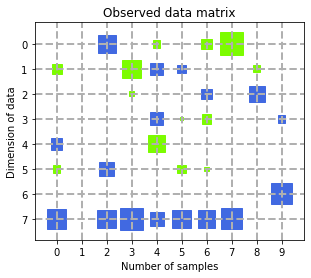

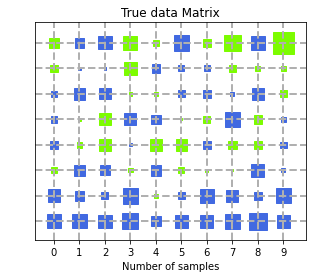

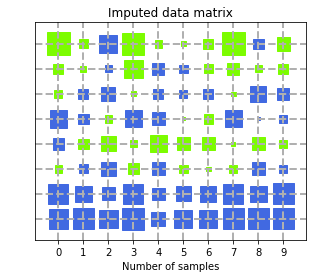

In [13]:
gen_imputer_data()

In [14]:
from ipywidgets import interact
import ipywidgets as widgets


@interact(
    data_dim=widgets.IntSlider(description="data_dim", min=5, max=15, value=10, continuous_update=False),
    sample_size=widgets.IntSlider(description="sample_size", min=5, max=15, value=10, continuous_update=False),
    threshold_missing=widgets.FloatSlider(
        description="threshold_missing",
        min=0,
        max=1,
        value=0.5,
        step=0.1,
        continuous_update=False,
    ),
)
def update(data_dim, sample_size, threshold_missing):
    gen_imputer_data(data_dim=data_dim, sample_size=sample_size, threshold_missing=threshold_missing)

interactive(children=(IntSlider(value=10, continuous_update=False, description='data_dim', max=15, min=5), Int…